In [1]:
# Box prediction
# Trying again!
import time
from PIL import Image, ImageDraw
import numpy as np

import torch
import torch.nn as nn
from skimage import io
import math

from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import os

import seaborn as sns
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import matplotlib.transforms as mplTransforms
from datetime import datetime
plt.style.use('ggplot')


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("CUDA available? device: ", device)

# ---- Make depth images ------------------------------------
# -----------------------------------------------------------
IMG_X, IMG_Y = 200, 200
# length and width of blocks (fixed for now)
block_l, block_w = 20, 30

batch_size = 15


# -- Calc rectangle vertices. credit Sparkler, stackoverflow, feb 17
def makeRectangle(l, w, theta, offset=(0, 0)):
    c, s = math.cos(theta), math.sin(theta)
    rectCoords = [(l / 2.0, w / 2.0), (l / 2.0, -w / 2.0),
                  (-l / 2.0, -w / 2.0), (-l / 2.0, w / 2.0)]
    return np.array([(c * x - s * y + offset[0], s * x + c * y + offset[1]) for (x, y) in rectCoords]).flatten()
    #return np.array([(c * x - s * y + offset[0], s * x + c * y + offset[1]) for (x, y) in rectCoords])


# ---- Save to file -------------------
def make_dataset(dirname, num_images):
    true_coords = []
    newpath = "./" + dirname
    if not os.path.exists(newpath):
        os.makedirs(newpath)
        print(newpath)
    for i in range(num_images):
        # orient = 0 # degrees
        img = Image.new("RGB", (IMG_X, IMG_Y), "black")

        # block_l and _w offset so blocks don't run off edge of image
        rand_x = int(np.random.rand() * (IMG_X - 2 * block_l)) + block_l
        rand_y = int(np.random.rand() * (IMG_Y - 2 * block_w)) + block_w
        orient = int(np.random.rand() * 180)  # .random() is range [0.0, 1.0).
        orient = math.radians(orient)  # math.cos takes radians!

        rect_vertices = makeRectangle(
            block_l, block_w, orient, offset=(rand_x, rand_y))

        # true_coords.append(np.array((rand_x, rand_y, math.degrees(orient))))
        #true_coords.append(np.array([rand_y, rand_x, np.cos(orient), np.sin(orient)]))
        true_coords.append(np.array(rect_vertices))
        
        idraw = ImageDraw.Draw(img)
        idraw.polygon(rect_vertices, fill="white")

        img.save(newpath + "/rect" + str(i) + ".png")
    return true_coords


# ---- Define dataloader ------------------------------------
# -----------------------------------------------------------
class RectDepthImgsDataset(Dataset):
    """Artificially generated depth images dataset"""

    def __init__(self, img_dir, coords, transform=None):
        self.img_dir = img_dir
        self.true_coords = coords
        self.transform = transform

    def __len__(self):
        # print('true coord len', len(self.true_coords))
        return len(self.true_coords)

    def __getitem__(self, idx):
        # image = self.images[idx]
        image = io.imread(self.img_dir + '/rect' + str(idx) + '.png')
        image = torch.FloatTensor(image).permute(
            2, 0, 1)  # PIL and torch expect difft orders
        coords = torch.FloatTensor(self.true_coords[idx])

        if self.transform:
            image = self.transform(image)

        # sample = {'image': image, 'grasp': str(coords[0]) + str(coords[1])}
        sample = {'image': image, 'grasp': coords}
        sample = image, coords

        return sample


# ---- Define Net ------------------------------------
# ----------------------------------------------------
class Net(nn.Module):  # CIFAR is 32x32x3, MNIST is 28x28pred_x)
    def __init__(self, IMG_X, IMG_Y):
        super(Net, self).__init__()

        self._imgx = IMG_X
        self._imgy = IMG_Y
        _pool = 2
        _stride = 5
        _outputlayers = 16

        num_classes = 8

        def _calc(val):
            layer_size = (val - (_stride - 1)) / _pool
            return layer_size

        # print(self._imgx)
        self._const = _calc(_calc(self._imgx))
        self._const *= _calc(_calc(self._imgy))
        self._const *= _outputlayers
        # print(self._const)
        self._const = int(self._const)

        self.conv1 = nn.Conv2d(3, 6, _stride).to(device)
        self.pool = nn.MaxPool2d(_pool, _pool).to(device)
        self.conv2 = nn.Conv2d(6, _outputlayers, _stride).to(device)
        self.fc1 = nn.Linear(self._const, 120).to(device)
        self.fc2 = nn.Linear(120, 84).to(device)
        self.fc3 = nn.Linear(84, num_classes).to(device)

    def forward(self, x):
        # print(x.size())
        x = x.to(device)
        x = x.view(-1, 3, IMG_X, IMG_Y)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, self._const)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# -- Utility fxn -------------------------------------
# Source: https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Object-Detection/blob/master/train.py
# ---------------------------------------------------


class AverageMeter(object):
    """
    Keeps track of most recent, average, sum, and count of a metric.
    """

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def save_checkpoint(epoch, epochs_since_improvement, regrModel,
                    loss_history,
                    regrLoss, best_loss, is_best):
    # Save checkpoint
    """
    Save model checkpoint.
    :param epoch: epoch number
    :param epochs_since_improvement: number of epochs since last improvement
    :param model: model
    :param optimizer: optimizer
    :param loss: validation loss in this epoch
    :param best_loss: best validation loss achieved so far (not necessarily in this checkpoint)
    :param is_best: is this checkpoint the best so far?
    """
    state = {
        "epoch": epoch,
        "epochs_since_improvement": epochs_since_improvement,
        "regrModel": regrModel,
        "regrLoss": regrLoss,
        "loss_history": loss_history,
        "best_loss": best_loss,
        "is_best": is_best
    }

    filename = "checkpoint_attempt2.tar"
    torch.save(state, filename)
    # If this checkpoint is the best so far, store a copy so it doesn't get overwritten by a worse checkpoint
    if is_best:
        torch.save(state, "BEST_" + filename)

# -- Main Functions --------------------------------------------------
# --------------------------------------------------------------------


def run_dataset_creation():
    train_truth = make_dataset('data', 2500)
    print(len(train_truth))
    test_truth = make_dataset('./data/test', 300)
    # to things

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("CUDA available? device: ", device)

    # Dataset is depth images of rectangular blocks
    global train_loader
    train_dataset = RectDepthImgsDataset(img_dir='./data', coords=train_truth)
    # Data loader
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size,
                              shuffle=True)

    test_dataset = RectDepthImgsDataset(
        img_dir='./data/test', coords=test_truth)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size,
                             shuffle=True)

    np.save("train_truth.npy", train_truth)
    np.save("test_truth.npy", test_truth)


def train_dataset():

    num_classes = 3  # predicting x,y,orientation
    learning_rate = 0.001
    criterion = nn.MSELoss()
    num_epochs = 40 

    print_freq = 25  # print training or validation status every __ batches
    epochs_since_improvement = 0
    best_loss = 5000.0  # assume a high loss at first

    train_truth = np.load("train_truth.npy")
    # loading the training and testing data5
    test_truth = np.load("test_truth.npy")

    batch_time = AverageMeter()  # forward prop. + back prop. time
    data_time = AverageMeter()  # data loading time
    loss_avg = AverageMeter()  # loss
    loss_history = []

    # -- Instantiate CNN -------------------------
    regrModel = Net(IMG_X, IMG_Y)
    regrModel = regrModel.to(device)
    optimizer = torch.optim.Adam(regrModel.parameters(), lr=learning_rate)

    regrModel.train()  # enable dropout
    print('Training model now...')

    # -- Load datasets -------------------------
    train_truth = np.load("train_truth.npy")
    train_dataset = RectDepthImgsDataset(img_dir='./data', coords=train_truth)
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size,
                              shuffle=True)

    # -- Begin training -------------------------
    print('Start time: ',  datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
    start = time.time()

    for epoch in range(num_epochs):

        for i_batch, (images, labels) in enumerate(train_loader):
            data_time.update(time.time() - start)

            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = regrModel(images).to(device)

            regrLoss = criterion(outputs, labels)
            loss_history.append(regrLoss)

            optimizer.zero_grad()
            regrLoss.backward()

            # Update Model
            optimizer.step()

            loss_avg.update(regrLoss.item())

            # Print status
            batch_time.update(time.time() - start)
            start = time.time()

            if i_batch % print_freq == 0:
                print(
                    "Epoch: [{0}][{1}/{2}]\t"
                    "Batch Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t"
                    "Loss {loss.val:.4f} (Avg {loss.avg:.4f})\t".format(
                        epoch,
                        i_batch,
                        len(train_loader),
                        batch_time=batch_time,
                        loss=loss_avg,
                    )
                )

        # One epoch's loss
        is_best = loss_avg.avg < best_loss
        best_loss = min(loss_avg.avg, best_loss)

        if not is_best:
            epochs_since_improvement += 1
            print("\nEpochs since last improvement: %d, %d loss\n" %
                  (epochs_since_improvement, loss_avg.avg))

        else:
            epochs_since_improvement = 0

        # Save checkpoint
        save_checkpoint(epoch, epochs_since_improvement, regrModel,
                        loss_history,
                        loss_avg.avg, best_loss, is_best)
    print('End time: ',  datetime.now().strftime('%Y-%m-%d %H:%M:%S'))


# --- VIEW RESULTS ----------------------------------------
# ---------------------------------------------------------

def view_loss_results():
    filename = "checkpoint_attempt2.tar"
    checkpoint = torch.load(filename)
    start_epoch = checkpoint['epoch'] + 1
    best_loss = checkpoint['best_loss']
    loss_history = checkpoint['loss_history']
    regrModel = checkpoint['regrModel']

    print('\nLoaded checkpoint from epoch %d. Best loss so far is %.3f.\n' %
          (start_epoch, best_loss))
    test_truth = np.load("test_truth.npy")
    test_dataset = RectDepthImgsDataset(
        img_dir='./data/test', coords=test_truth)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size,
                             shuffle=True)

    criterion = nn.MSELoss()

    with torch.no_grad():

        dataiter = iter(test_loader)
        images, labels = dataiter.next()

        # Move to default device
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = regrModel(images)
        loss = criterion(outputs, labels)

        # Loss
        print("loss across batch size of ", labels.size()[0], 'is: \n', loss)

        # print(labels)
        print('\n!-- labels size', labels.size())

        plt.plot(range(len(loss_history)), loss_history)  # regr loss
        plt.show()
        # plt.xlim((4500, 5100))
        # plt.ylim((0,30))
        # plt.show()

        # sns.regplot(x=np.arange(len(loss_history)),
        # y=np.array(loss_history)) # regr loss


def view_image_results():
    filename = "checkpoint_attempt2.tar"
    checkpoint = torch.load(filename)
    start_epoch = checkpoint['epoch'] + 1
    best_loss = checkpoint['best_loss']
    loss_history = checkpoint['loss_history']
    regrModel = checkpoint['regrModel']

    print('\nLoaded checkpoint from epoch %d. Best loss so far is %.3f.\n' %
          (start_epoch, best_loss))

    test_truth = np.load("test_truth.npy")
    test_dataset = RectDepthImgsDataset(
        img_dir='./data/test', coords=test_truth)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size,
                             shuffle=True)

    criterion = nn.MSELoss()

    with torch.no_grad():

        dataiter = iter(test_loader)
        images, coords = dataiter.next()

        # Move to default device
        images = images.to(device)
        coords = coords.to(device)

        # Forward pass
        outputs = regrModel(images)

        labels = coords.cpu()

        plt.rcParams['figure.figsize'] = [50, 10]

        fig, ax = plt.subplots()

        print('lenlabels', len(labels))
        print(block_l, block_w, IMG_X, IMG_Y)

        for i in range(len(labels) - 10):
            #print('i', i)
            #cornerUR, cornerLR, cornerLL, cornerUL = labels[i].numpy()
            corners = labels[i].numpy()
            pred_corners = outputs[i].cpu().numpy()
            print('i', i, 'truth: ', corners, 'pred:', pred_corners) 
            
            unflattened_corners = []
            pred_unflattened_corners = []
            for j in range(4):
                tmpx = corners[2 * j] + (i * IMG_X)
                tmpy = corners[(2 * j) + 1]
                pred_tmpx = pred_corners[2 * j] + (i * IMG_X)
                pred_tmpy = pred_corners[(2 * j) + 1]
                unflattened_corners.append((tmpx, tmpy))
                pred_unflattened_corners.append((pred_tmpx, pred_tmpy))
            unflattened_corners = np.array(unflattened_corners)
            pred_unflattened_corners = np.array(pred_unflattened_corners)
                

                
            # -- Plot truth rectangle 
            truth_rect = patches.Polygon(unflattened_corners, closed=True, fill=True, color='black')
            # correct for rotation around LL corner
            ax.add_patch(truth_rect)
            

            # -- Plot prediction
            pred_rect = patches.Polygon(pred_unflattened_corners, closed=True, fill=True, color='orange')
            # correct for rotation around LL corner
            ax.add_patch(pred_rect)
            
            # -- Plot image border 
            image_outline = patches.Rectangle((i * IMG_X, 0), 200, 200, angle=0, fill=False, color='black')
            ax.add_patch(image_outline)

            # Scatter plot of true centers
            # TODO: add logic to offset back to center correctly (accounting for theta)
            x, y = corners[0], corners[1]
            x, y = x - (block_l/2.0), y - (block_w/2.0)
            ax.scatter(x + i * IMG_X, y, color='r', marker='x', linewidth='1',
                       zorder=100)
        ax.set_aspect('equal', 'box')
        plt.show()


def main():
    print('Creating dataset')
    run_dataset_creation()

    print('Training model')
    train_dataset()

    print('View results')

    #view_loss_results()
    view_image_results()

    #input('Close all?')
    plt.close('all')


#if __name__ == '__main__':
    #main()

CUDA available? device:  cuda:0


Creating dataset
2500
CUDA available? device:  cuda:0
Training model
Training model now...
Start time:  2019-03-27 00:24:11
Epoch: [0][0/167]	Batch Time 0.073 (0.073)	Loss 12564.8145 (Avg 12564.8145)	
Epoch: [0][25/167]	Batch Time 0.047 (0.049)	Loss 1657.4719 (Avg 6915.5684)	
Epoch: [0][50/167]	Batch Time 0.045 (0.049)	Loss 2415.1868 (Avg 4610.9029)	
Epoch: [0][75/167]	Batch Time 0.047 (0.049)	Loss 2628.9377 (Avg 3786.1770)	
Epoch: [0][100/167]	Batch Time 0.055 (0.049)	Loss 1847.0017 (Avg 3342.1685)	
Epoch: [0][125/167]	Batch Time 0.045 (0.049)	Loss 2302.1877 (Avg 3080.2499)	
Epoch: [0][150/167]	Batch Time 0.056 (0.049)	Loss 1553.2729 (Avg 2927.4396)	


/home/rui/mlenv/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: [1][0/167]	Batch Time 0.242 (0.050)	Loss 1995.6638 (Avg 2830.4040)	
Epoch: [1][25/167]	Batch Time 0.046 (0.050)	Loss 2311.4666 (Avg 2708.1378)	
Epoch: [1][50/167]	Batch Time 0.055 (0.050)	Loss 2180.1709 (Avg 2621.4700)	
Epoch: [1][75/167]	Batch Time 0.058 (0.049)	Loss 2154.5771 (Avg 2552.5261)	
Epoch: [1][100/167]	Batch Time 0.047 (0.049)	Loss 1594.5103 (Avg 2487.7263)	
Epoch: [1][125/167]	Batch Time 0.045 (0.049)	Loss 2239.6404 (Avg 2429.6049)	
Epoch: [1][150/167]	Batch Time 0.047 (0.050)	Loss 2050.2861 (Avg 2381.0116)	
Epoch: [2][0/167]	Batch Time 0.163 (0.050)	Loss 1625.4183 (Avg 2350.5740)	
Epoch: [2][25/167]	Batch Time 0.049 (0.050)	Loss 1710.9551 (Avg 2308.3295)	
Epoch: [2][50/167]	Batch Time 0.049 (0.050)	Loss 2298.2239 (Avg 2286.2173)	
Epoch: [2][75/167]	Batch Time 0.047 (0.050)	Loss 1863.0308 (Avg 2253.7890)	
Epoch: [2][100/167]	Batch Time 0.048 (0.049)	Loss 1812.0238 (Avg 2229.4246)	
Epoch: [2][125/167]	Batch Time 0.052 (0.049)	Loss 1379.5977 (Avg 2206.8961)	
Epoch: [2

Epoch: [16][50/167]	Batch Time 0.049 (0.050)	Loss 1633.6196 (Avg 1833.6206)	
Epoch: [16][75/167]	Batch Time 0.049 (0.050)	Loss 2334.6489 (Avg 1833.3259)	
Epoch: [16][100/167]	Batch Time 0.049 (0.050)	Loss 1623.0907 (Avg 1832.3117)	
Epoch: [16][125/167]	Batch Time 0.049 (0.050)	Loss 1735.7947 (Avg 1832.2195)	
Epoch: [16][150/167]	Batch Time 0.057 (0.050)	Loss 1603.7878 (Avg 1831.1480)	
Epoch: [17][0/167]	Batch Time 0.534 (0.050)	Loss 1218.7819 (Avg 1830.8665)	
Epoch: [17][25/167]	Batch Time 0.049 (0.050)	Loss 1448.6464 (Avg 1829.6934)	
Epoch: [17][50/167]	Batch Time 0.049 (0.050)	Loss 1879.6554 (Avg 1829.4764)	
Epoch: [17][75/167]	Batch Time 0.047 (0.050)	Loss 1532.4929 (Avg 1828.7615)	
Epoch: [17][100/167]	Batch Time 0.049 (0.050)	Loss 1271.4792 (Avg 1828.9087)	
Epoch: [17][125/167]	Batch Time 0.049 (0.050)	Loss 1596.3677 (Avg 1827.5056)	
Epoch: [17][150/167]	Batch Time 0.062 (0.050)	Loss 1650.9677 (Avg 1827.4095)	
Epoch: [18][0/167]	Batch Time 0.412 (0.051)	Loss 2773.7354 (Avg 1826.73

Epoch: [31][100/167]	Batch Time 0.049 (0.052)	Loss 2448.2778 (Avg 1787.1968)	
Epoch: [31][125/167]	Batch Time 0.049 (0.052)	Loss 2148.9016 (Avg 1787.0719)	
Epoch: [31][150/167]	Batch Time 0.049 (0.052)	Loss 1939.9719 (Avg 1786.8237)	
Epoch: [32][0/167]	Batch Time 0.692 (0.052)	Loss 1464.3787 (Avg 1786.0928)	
Epoch: [32][25/167]	Batch Time 0.049 (0.052)	Loss 1428.7435 (Avg 1785.5770)	
Epoch: [32][50/167]	Batch Time 0.049 (0.052)	Loss 1313.0300 (Avg 1785.2973)	
Epoch: [32][75/167]	Batch Time 0.047 (0.052)	Loss 1918.1211 (Avg 1784.7542)	
Epoch: [32][100/167]	Batch Time 0.047 (0.052)	Loss 1409.5581 (Avg 1784.7104)	
Epoch: [32][125/167]	Batch Time 0.047 (0.052)	Loss 1827.9329 (Avg 1785.0365)	
Epoch: [32][150/167]	Batch Time 0.049 (0.052)	Loss 1393.6294 (Avg 1784.2829)	
Epoch: [33][0/167]	Batch Time 0.703 (0.052)	Loss 1638.0396 (Avg 1784.2771)	
Epoch: [33][25/167]	Batch Time 0.049 (0.052)	Loss 1695.7340 (Avg 1784.0913)	
Epoch: [33][50/167]	Batch Time 0.049 (0.052)	Loss 1850.8031 (Avg 1783.90

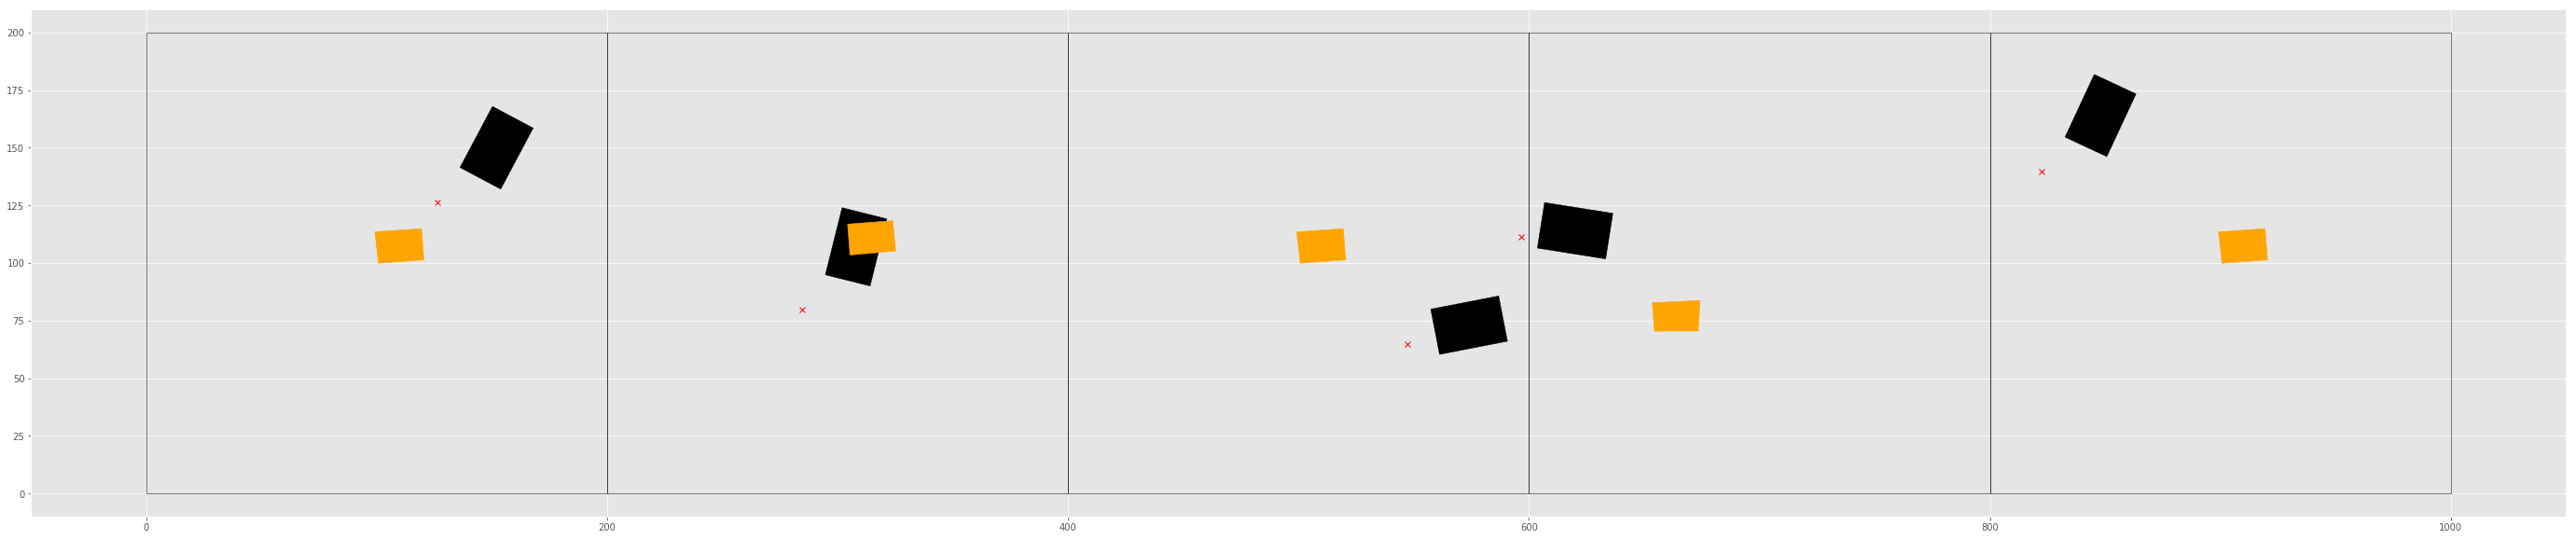

In [2]:
main()

verts [(10.0, 15.0), (10.0, -15.0), (-10.0, -15.0), (-10.0, 15.0)]
0
1
2
3
[(10.0, 15.0), (10.0, -15.0), (-10.0, -15.0), (-10.0, 15.0)]


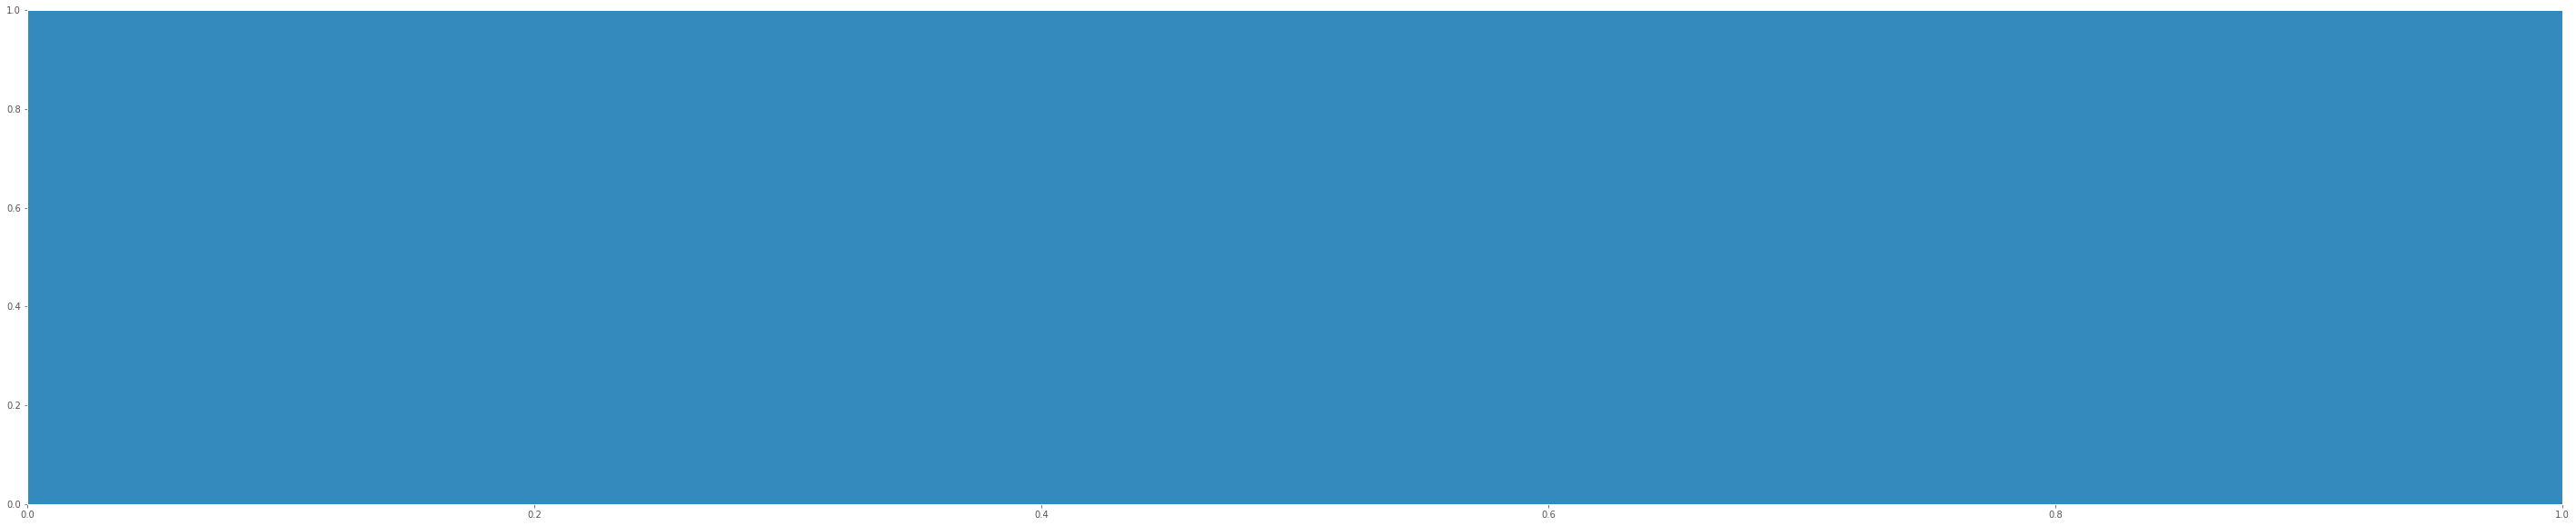

In [3]:
# -- Calc rectangle vertices. credit Sparkler, stackoverflow, feb 17
def makeRectangle(l, w, theta, offset=(0, 0)):
    c, s = math.cos(theta), math.sin(theta)
    rectCoords = [(l / 2.0, w / 2.0), (l / 2.0, -w / 2.0),
                  (-l / 2.0, -w / 2.0), (-l / 2.0, w / 2.0)]
    #return np.array([(c * x - s * y + offset[0], s * x + c * y + offset[1]) for (x, y) in rectCoords]).flatten()
    return [(c * x - s * y + offset[0], s * x + c * y + offset[1]) for (x, y) in rectCoords]

verts = makeRectangle(20,30,0)
print('verts', verts)
verts = np.array(verts).flatten()
unflat = []
for i in range(4):
    print(i)
    tmpx = verts[2 * i]
    tmpy = verts[(2 * i) + 1]
    unflat.append((tmpx, tmpy))
print(unflat)

fig, ax = plt.subplots()
poly = patches.Polygon(unflat, fill=True)
ax.add_patch(poly)
plt.show()